2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터

## features

- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수

## target

- box_off_num : 관객수

# 1. Libraries & Data

In [1]:
# 라이브러리
import pandas as pd # 데이터 처리하는 라이브러리
import seaborn as sns # 데이터 시각화 라이브러리

# model
import lightgbm as lgb

In [2]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/KaggleStudy/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/KaggleStudy/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/KaggleStudy/submission.csv')

# 2. 탐색적 자료분석(EDA)
#### pd.DataFrame.head()
- 데이터 프레임의 위에서부터 n개 행을 보여주는 함수
- n의 default: 5

#### pd.DataFrame.tail()
- 데이터 프레임의 아래에서부터 n개 행을 보여주는 함수
- n의 default: 5

In [3]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [4]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [5]:
submission.head() # 제출용 답안지

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


#### pd.DataFrame.shape
- 데이터 프레임의 행/열 개수가 저장되어 있는 속성(attribute)

In [6]:
print(train.shape) # 정답(관객수) column 있음
print(test.shape) # 정답 column 없음 -> 직접 예측해서 데이콘에 제출해야 오차 확인 가능
print(submission.shape) # test 데이터의 정답 적음. 제출용

(600, 12)
(243, 11)
(243, 2)


#### pd.DataFrame.info()
- 데이터셋의 column별 정보를 알려주는 함수
- 비어있지 않은 값(non-null)의 개수
- column의 type
  - int, float, object(문자열) 등등

In [7]:
train.info()
# 7번 column이 상당수 비어있으므로 추후 모델링을 위해서는 채워줘야 함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


#### pd.DataFrame.describe()
- 숫자형(int, float) column들의 기술 통계량을 보여주는 함수

In [9]:
train.describe()
# e+02 -> 10의 2승 곱함

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


#### pd.DataFrame.groupby(a)
- 집단에 대한 통계량 확인
- a에 따라 그룹을 만들어줌

In [10]:
train[['genre','box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


#### pd.DataFrame.corr()
* 상관계수: 보통 0.4 이상이면 상관이 있다고 봄

In [11]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


<Axes: >

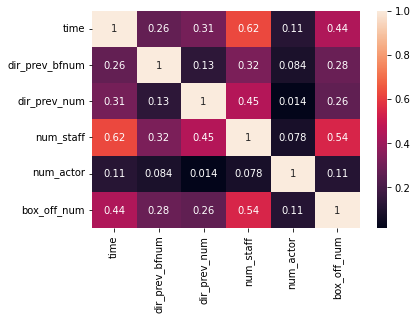

In [12]:
sns.heatmap(train.corr(),annot=True)

관객수(box_off_num)에 대해 예측해야 함.
- num_staff(0.54)의 상관관계가 커 보임
- time(0.44)의 상관관계가 커 보임

# 3. 데이터 전처리
#### pd.Series.isna()
- 결측치 여부 확인
- 결측치면 True(1), 아니면 False(0)

In [13]:
train.isna().sum()/600

title             0.00
distributor       0.00
genre             0.00
release_time      0.00
time              0.00
screening_rat     0.00
director          0.00
dir_prev_bfnum    0.55
dir_prev_num      0.00
num_staff         0.00
num_actor         0.00
box_off_num       0.00
dtype: float64

In [14]:
train[train['dir_prev_bfnum'].isna()] # 결측치가 있는 행만 추출

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745
...,...,...,...,...,...,...,...,...,...,...,...,...
593,낭만파 남편의 편지,퍼스트런,미스터리,2013-09-12,97,청소년 관람불가,최위안,NaN,0,5,3,1132
594,오빠가 돌아왔다,(주)마운틴픽쳐스,코미디,2014-03-20,94,청소년 관람불가,노진수,NaN,0,37,5,1958
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [15]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()
# 결측값이 있는 행은 dir_prev_num 값도 모두 0이다.

0

#### pd.DataFrame.fillna()
- 결측치를 채우고자 하는 column과 결측치를 대신하여 넣고싶은 값을 인자로 넣음
- 범주형 변수의 경우 최빈값으로 대체 가능

In [16]:
train['dir_prev_bfnum'].fillna(0, inplace=True)
# 0으로 결측값 채워 넣음
# inplace=True -> 저장도 됨

In [17]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [18]:
test[test['dir_prev_bfnum'].isna()]['dir_prev_bfnum'].sum()

0.0

In [19]:
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [20]:
test['dir_prev_bfnum'].isna().sum()

0

# 4. 모델링
- 영화 관객수 예측 모델 제작
  - input: x(여러가지 feature들)
  - model(light gbm)
  - output: y

## light gbm
[document](https://lightgbm.readthedocs.io/en/v3.3.2/Python-API.html#data-structure-api)

- 2가지 버전 존재
  - Training API
  - Scikit-learn API
     - Scikit-learn과 문법 동일

- LGBMRegrssor 사용



In [21]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)
# radom_state: 실험 상황 고정
# n_estimators: 순차적으로 n개의 모델 제작

In [22]:
features = ['time', 'dir_prev_num', 'num_staff','num_actor']
target = ['box_off_num']

In [23]:
X_train, X_test, y_train = train[features], test[features], train[target]

# 5. 모델 학습(Tuning) 및 평가(Evaluation)

a. base model(lightGBM)    
b. k-fold model(k-fold lightGBM)  
c. fe(feature engineering)    
d. hyperparameter tuning(grid search)


* a->d로 갈수록 모델 성능 좋아짐


In [24]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [25]:
singleGBM = submission.copy()

In [30]:
singleGBM.head()

,title,box_off_num
0,용서는 없다,2.817995e+06
1,아빠가 여자를 좋아해,3.753772e+05
2,하모니,-5.693243e+05
3,의형제,1.581189e+06
4,평행 이론,-5.277806e+05


In [29]:
singleGBM['box_off_num'] = model.predict(X_test)

In [28]:
singleGBM.to_csv('singleGBM.csv', index=False)

#### k-fold 교차검증

In [31]:
from sklearn.model_selection import KFold

In [32]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.00,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0.00,0,431,4,2192525


In [33]:
k_fold = KFold(n_splits=5,shuffle=True,random_state=777)

In [37]:
k_fold.split

<bound method _BaseKFold.split of KFold(n_splits=5, random_state=777, shuffle=True)>

In [36]:
for train_idx, val_idx in k_fold.split(X_train):
  print(len(train_idx), len(val_idx)) # 총 600
  break

480 120


In [38]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]

  models.append(model.fit(x_t,y_t, eval_set=(x_val,y_val), early_stopping_rounds=100, verbose=100))

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.70572e+12
[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


In [39]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [41]:
preds = []
for model in models: 
  preds.append(model.predict(X_test))
len(preds)

5

In [43]:
preds

[array([3367422.08211024,  961138.88337016, 1097929.67851313,
        2097270.81999921,  781476.31131047,  123133.23396977,
          84085.01896248,  199222.92670303,  124854.97973097,
        1072684.78820647,  657040.55769984, 1644701.47160779,
         924735.72080619,  191699.58415836,  723218.39948755,
        2395613.42888462,  113180.54906592, 1882765.92812296,
          97286.47282983,  417270.42113431,  161482.3367577 ,
          63495.73363115,  598057.42337284,  249411.25868881,
         308424.71884273, 1319518.60852241,  202273.52740684,
        1076683.13768137,  491636.41945325,  183406.6380314 ,
        1740233.45816734,   86696.17528125,  440430.29773088,
        2040944.13061099,  113375.45695331,  531746.29484356,
         106207.35971699,  169560.79581187,  158101.0895316 ,
          95037.29701059,  466355.50624629,  197548.63265325,
         198810.0901353 ,  682743.4340129 ,  679265.22397749,
         617812.91125278,  219182.85833837,   83712.10602149,
        

In [44]:
kfoldLightGBM = submission.copy()

In [42]:
import numpy as np

In [45]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis=0)

In [46]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


In [47]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index=False)